In [1]:
import pandas as pd

# Column names: 2 ID fields + 3 operational settings + 21 sensors = 26 total columns
cols = ['engine_id', 'cycle'] + [f'op_setting{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]

# Load training data
df = pd.read_csv('/kaggle/input/turbofan-cmapss/train_FD001.txt', sep='\s+', header=None, names=cols)

# Compute RUL
rul_df = df.groupby('engine_id')['cycle'].max().reset_index()
rul_df.columns = ['engine_id', 'max_cycle']
df = df.merge(rul_df, on='engine_id')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)

# Show preview
print(df.head())


   engine_id  cycle  op_setting1  op_setting2  op_setting3  sensor1  sensor2  \
0          1      1      -0.0007      -0.0004        100.0   518.67   641.82   
1          1      2       0.0019      -0.0003        100.0   518.67   642.15   
2          1      3      -0.0043       0.0003        100.0   518.67   642.35   
3          1      4       0.0007       0.0000        100.0   518.67   642.35   
4          1      5      -0.0019      -0.0002        100.0   518.67   642.37   

   sensor3  sensor4  sensor5  ...  sensor13  sensor14  sensor15  sensor16  \
0  1589.70  1400.60    14.62  ...   2388.02   8138.62    8.4195      0.03   
1  1591.82  1403.14    14.62  ...   2388.07   8131.49    8.4318      0.03   
2  1587.99  1404.20    14.62  ...   2388.03   8133.23    8.4178      0.03   
3  1582.79  1401.87    14.62  ...   2388.08   8133.83    8.3682      0.03   
4  1582.85  1406.22    14.62  ...   2388.04   8133.80    8.4294      0.03   

   sensor17  sensor18  sensor19  sensor20  sensor21  RUL

In [2]:
import pandas as pd

# Define column names
column_names = ['engine_id', 'cycle'] + [f'op_setting{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]

# Load training data
df = pd.read_csv("/kaggle/input/turbofan-cmapss/train_FD001.txt", sep='\s+', header=None, names=column_names)

# View top rows
print(df.head())


   engine_id  cycle  op_setting1  op_setting2  op_setting3  sensor1  sensor2  \
0          1      1      -0.0007      -0.0004        100.0   518.67   641.82   
1          1      2       0.0019      -0.0003        100.0   518.67   642.15   
2          1      3      -0.0043       0.0003        100.0   518.67   642.35   
3          1      4       0.0007       0.0000        100.0   518.67   642.35   
4          1      5      -0.0019      -0.0002        100.0   518.67   642.37   

   sensor3  sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  \
0  1589.70  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195   
1  1591.82  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318   
2  1587.99  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178   
3  1582.79  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682   
4  1582.85  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294   

   sensor16  sensor17  sensor18  sensor19  sensor20  sen

**Computing Remaining Useful Life (RUL)**

In [3]:
# Calculate max cycle per engine
rul = df.groupby('engine_id')['cycle'].max().reset_index()
rul.columns = ['engine_id', 'max_cycle']

# Merge and calculate RUL
df = df.merge(rul, on='engine_id')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)

# Preview RUL-added data
print(df[['engine_id', 'cycle', 'RUL']].head())

   engine_id  cycle  RUL
0          1      1  191
1          1      2  190
2          1      3  189
3          1      4  188
4          1      5  187


**Initial Exploratory Data Analysis (EDA)**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


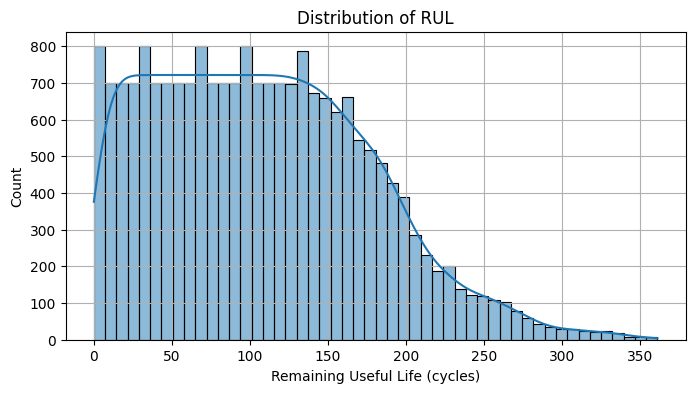

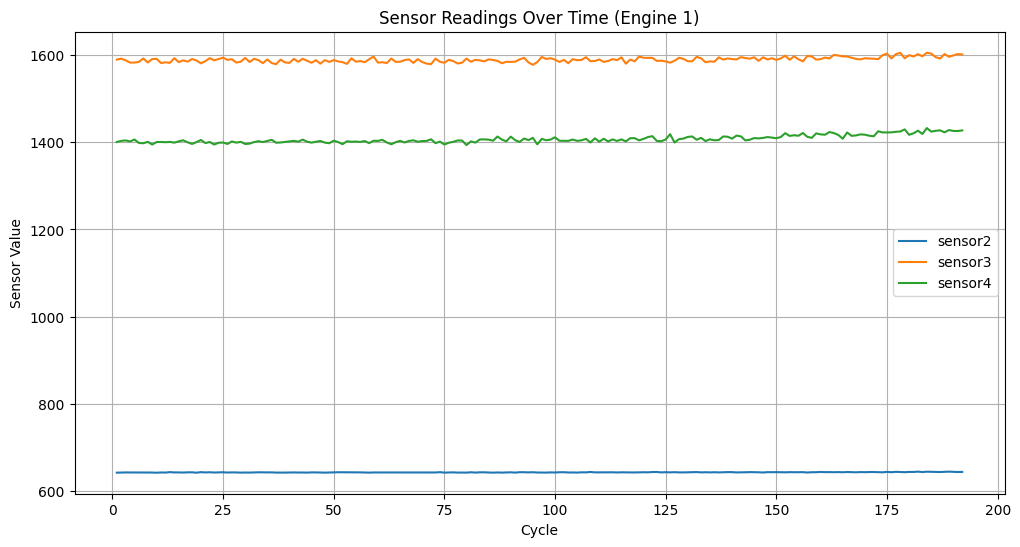

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Distribution of RUL
plt.figure(figsize=(8,4))
sns.histplot(df['RUL'], bins=50, kde=True)
plt.title("Distribution of RUL")
plt.xlabel("Remaining Useful Life (cycles)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Example: Sensor trend over time for a single engine
engine_1 = df[df['engine_id'] == 1]
plt.figure(figsize=(12,6))
for s in ['sensor2', 'sensor3', 'sensor4']:
    plt.plot(engine_1['cycle'], engine_1[s], label=s)
plt.xlabel("Cycle")
plt.ylabel("Sensor Value")
plt.title("Sensor Readings Over Time (Engine 1)")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Drop operational settings for now (can include later)
sensor_columns = [col for col in df.columns if col.startswith('sensor')]

# Check variance of each sensor
sensor_variance = df[sensor_columns].var().sort_values()

# Remove near-zero variance sensors
low_variance = sensor_variance[sensor_variance < 0.01].index.tolist()
print("Low-variance sensors:", low_variance)

# Filter them out
useful_sensors = list(set(sensor_columns) - set(low_variance))
print("Remaining useful sensors:", useful_sensors)


Low-variance sensors: ['sensor19', 'sensor18', 'sensor16', 'sensor10', 'sensor5', 'sensor1', 'sensor6', 'sensor15', 'sensor8', 'sensor13']
Remaining useful sensors: ['sensor12', 'sensor7', 'sensor11', 'sensor20', 'sensor3', 'sensor9', 'sensor2', 'sensor21', 'sensor14', 'sensor17', 'sensor4']


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[useful_sensors] = scaler.fit_transform(df[useful_sensors])

In [7]:
# Example: Rolling features for sensor2 and sensor3
for sensor in ['sensor2', 'sensor3']:
    df[f'{sensor}_rollmean'] = df.groupby('engine_id')[sensor].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    df[f'{sensor}_rollstd']  = df.groupby('engine_id')[sensor].transform(lambda x: x.rolling(window=5, min_periods=1).std())
    df[f'{sensor}_delta']    = df.groupby('engine_id')[sensor].diff().fillna(0)


In [8]:
import numpy as np

def gen_lstm_sequences(data, seq_len=30, sensors=useful_sensors, max_rul=125):
    X, y = [], []
    for engine_id in data['engine_id'].unique():
        engine_df = data[data['engine_id'] == engine_id].reset_index(drop=True)
        for i in range(len(engine_df) - seq_len + 1):
            window = engine_df.loc[i:i+seq_len-1, sensors].values
            rul = engine_df.loc[i+seq_len-1, 'RUL']
            y.append(min(rul, max_rul))  # Clip RUL
            X.append(window)
    return np.array(X), np.array(y)

# Prepare LSTM-ready data
X_lstm, y_lstm = gen_lstm_sequences(df, seq_len=30, sensors=useful_sensors)
print("X shape:", X_lstm.shape)
print("y shape:", y_lstm.shape)


X shape: (17731, 30, 11)
y shape: (17731,)


In [9]:
# For each engine, generate samples up to N cycles before failure
window_size = 30

train_df = []
for engine_id in df['engine_id'].unique():
    engine_data = df[df['engine_id'] == engine_id]
    max_cycle = engine_data['cycle'].max()

    for i in range(len(engine_data) - window_size + 1):
        window = engine_data.iloc[i:i+window_size].copy()
        window['RUL'] = max_cycle - window.iloc[-1]['cycle']
        train_df.append(window.iloc[-1])  # Or aggregate features from the window

last_df = pd.DataFrame(train_df)


In [10]:
features = [f'op_setting{i}' for i in range(1, 4)] + useful_sensors

In [11]:
# Unique engine IDs
engine_ids = last_df['engine_id'].unique()

# Split by engine
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(engine_ids, test_size=0.2, random_state=42)

train_df = last_df[last_df['engine_id'].isin(train_ids)]
val_df = last_df[last_df['engine_id'].isin(val_ids)]

X_train = train_df[features]
y_train = train_df['RUL']

X_val = val_df[features]
y_val = val_df['RUL']


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_val)

# Evaluation
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Random Forest MAE: {mae:.2f}")
print(f"Random Forest RMSE: {rmse:.2f}")


Random Forest MAE: 22.40
Random Forest RMSE: 30.69


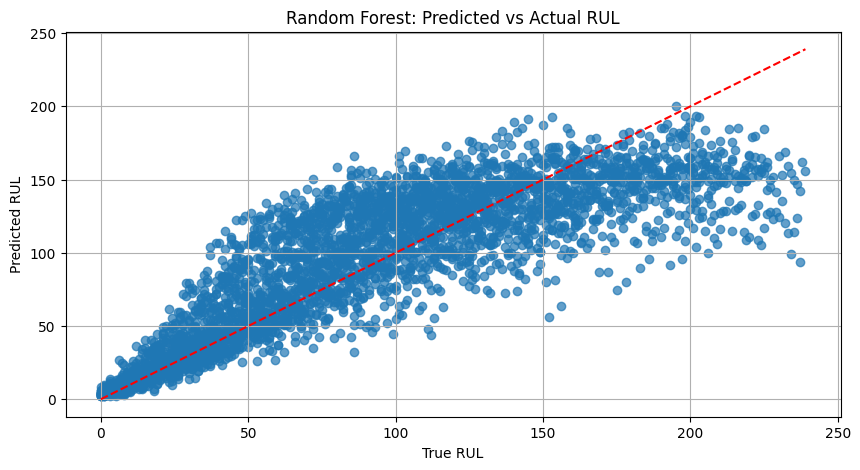

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_val, y_pred, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Random Forest: Predicted vs Actual RUL")
plt.grid(True)
plt.show()


In [14]:
# RUL = max_cycle - current_cycle for each engine
rul_df = df.groupby('engine_id')['cycle'].max().reset_index()
rul_df.columns = ['engine_id', 'max_cycle']
df = df.merge(rul_df, on='engine_id', how='left')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)

In [15]:
# Drop ID, time-based columns, and known non-informative sensors
drop_cols = ['id', 'max_cycle', 'RUL']  # keep RUL for target
sensor_drop = ['sensor1', 'sensor5', 'sensor6', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
df.drop(columns=sensor_drop, inplace=True)


In [16]:
from sklearn.preprocessing import StandardScaler

feature_cols = [col for col in df.columns if col not in ['engine_id', 'cycle', 'RUL']]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [17]:
# 📦 STEP: Prepare Sequences & Train LSTM for RUL Prediction

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [18]:
# === Load and preprocess ===
df = pd.read_csv("/kaggle/input/turbofan-cmapss/train_FD001.txt", sep=" ", header=None)
df.dropna(axis=1, inplace=True)
df.columns = ['engine_id', 'cycle'] + [f'op_mode{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]

# === RUL ===
rul_df = df.groupby('engine_id')['cycle'].max().reset_index()
rul_df.columns = ['engine_id', 'max_cycle']
df = df.merge(rul_df, on='engine_id', how='left')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)

# === Drop constant / irrelevant features ===
sensor_drop = ['sensor1', 'sensor5', 'sensor6', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
df.drop(columns=sensor_drop, inplace=True)


In [19]:
# === Normalize ===
feature_cols = [col for col in df.columns if col not in ['engine_id', 'cycle', 'RUL']]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# === Sequence Preparation ===
def create_sequences(df, seq_len=30):
    seq_data, labels = [], []
    for eng_id in df['engine_id'].unique():
        eng_df = df[df['engine_id'] == eng_id].reset_index(drop=True)
        for i in range(len(eng_df) - seq_len + 1):
            seq = eng_df[feature_cols].iloc[i:i+seq_len].values
            label = eng_df['RUL'].iloc[i+seq_len-1]
            seq_data.append(seq)
            labels.append(label)
    return np.array(seq_data), np.array(labels)


In [20]:
# === Create and split ===
seq_len = 30
X, y = create_sequences(df, seq_len=seq_len)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# === Dataset ===
class RULDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(RULDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(RULDataset(X_val, y_val), batch_size=64)

In [22]:
# === Model ===
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

model = LSTMRegressor(input_size=X.shape[2]).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
# === Train ===
epochs = 25
train_loss_list, val_loss_list = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch).squeeze()
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    train_loss_list.append(avg_train)
    val_loss_list.append(avg_val)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")
torch.save(model.state_dict(), "/kaggle/working/lstm_rul_model.pth")
print("Model saved at /kaggle/working/lstm_rul_model.pth")

Epoch 1/25 - Train Loss: 10796.6377, Val Loss: 9242.9840
Epoch 2/25 - Train Loss: 8394.2666, Val Loss: 7358.9272
Epoch 3/25 - Train Loss: 6728.6792, Val Loss: 5935.7480
Epoch 4/25 - Train Loss: 5449.0996, Val Loss: 4830.7873
Epoch 5/25 - Train Loss: 4453.1484, Val Loss: 3968.7087
Epoch 6/25 - Train Loss: 3672.0922, Val Loss: 3296.2235
Epoch 7/25 - Train Loss: 3060.6055, Val Loss: 2770.7546
Epoch 8/25 - Train Loss: 2579.6312, Val Loss: 2356.9616
Epoch 9/25 - Train Loss: 2200.7445, Val Loss: 2042.4036
Epoch 10/25 - Train Loss: 1903.7280, Val Loss: 1760.7740
Epoch 11/25 - Train Loss: 1676.4101, Val Loss: 1552.1900
Epoch 12/25 - Train Loss: 1493.4720, Val Loss: 1414.9440
Epoch 13/25 - Train Loss: 1337.2988, Val Loss: 1319.8871
Epoch 14/25 - Train Loss: 1235.9655, Val Loss: 1150.8963
Epoch 15/25 - Train Loss: 1118.4691, Val Loss: 1077.2424
Epoch 16/25 - Train Loss: 1038.1579, Val Loss: 986.3018
Epoch 17/25 - Train Loss: 992.7975, Val Loss: 953.6640
Epoch 18/25 - Train Loss: 936.4507, Val Lo

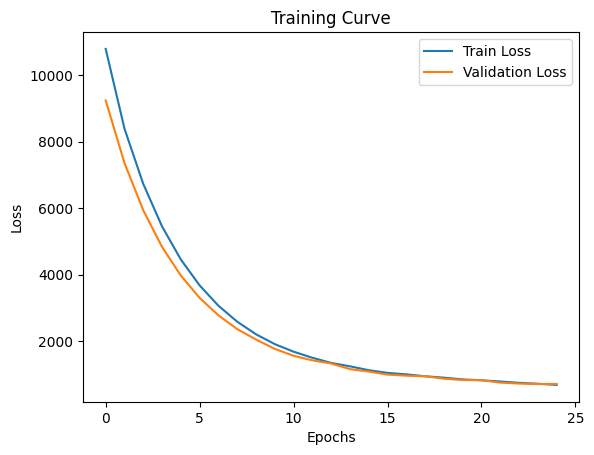

In [24]:
# === Plot losses ===
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curve')
plt.show()

**Alert Logic for RUL Prediction**

In [25]:
import torch
import numpy as np
import pandas as pd

# Ensure model is in eval mode
model.eval()

# Convert validation data to tensor (if not already)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# Move to device (GPU/CPU)
X_val_tensor = X_val_tensor.to(device)

# Predict
with torch.no_grad():
    y_pred_tensor = model(X_val_tensor)

# Move back to CPU and flatten
y_pred = y_pred_tensor.cpu().numpy().flatten()
y_val_flat = np.array(y_val).flatten()

# === ALERT LOGIC ===
ALERT_THRESHOLD = 20

alert_df = pd.DataFrame({
    'Engine_ID': np.arange(len(y_pred)),
    'Predicted_RUL': y_pred,
    'Actual_RUL': y_val_flat,
    'Alert': ['YES' if val < ALERT_THRESHOLD else 'NO' for val in y_pred]
})

# View and optionally save
print(alert_df[alert_df['Alert'] == 'YES'])


      Engine_ID  Predicted_RUL  Actual_RUL Alert
8             8      12.568573          21   YES
16           16       3.866297           9   YES
22           22      13.164369          13   YES
35           35      15.496248          20   YES
50           50       5.930640           6   YES
...         ...            ...         ...   ...
3526       3526       6.059264           7   YES
3533       3533       2.559740           1   YES
3541       3541       9.145520          11   YES
3542       3542       6.985765           6   YES
3544       3544      10.613033          20   YES

[414 rows x 4 columns]


In [26]:
alert_df.to_csv("alerts_triggered.csv", index=False)